In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from ugradiolab.data import Record
from ugradiolab.analysis import Spectrum

/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
DATA_DIR = Path('../../data')

nblock_files = sorted(DATA_DIR.glob('GAL-1420-n*.npz'),
                      key=lambda p: int(p.stem.split('-n')[1].split('_')[0]))

nblock_records  = [(int(p.stem.split('-n')[1].split('_')[0]), Record.load(p)) for p in nblock_files]
nblock_spectra  = [(n, Spectrum.from_record(rec)) for n, rec in nblock_records]

print(f'Found {len(nblock_spectra)} files:')
for n, spec in nblock_spectra:
    print(f'  nblocks={n:>5d}  total_power={spec.total_power:.4f}')

Found 3 files:
  nblocks=    8  total_power=1.3611
  nblocks=   32  total_power=1.3606
  nblocks=  128  total_power=1.3610


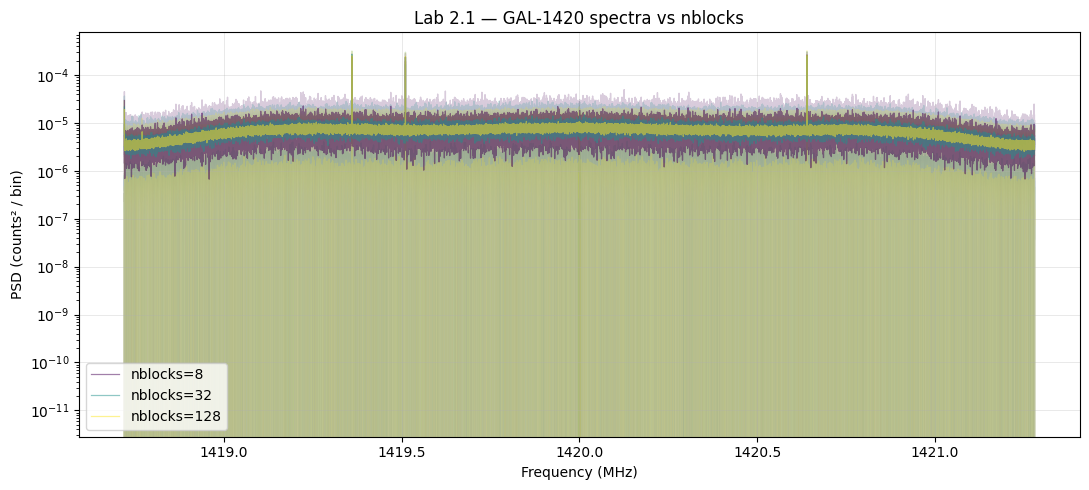

In [3]:
import numpy as np

cmap = plt.colormaps['viridis']
colors = [cmap(i / max(len(nblock_spectra) - 1, 1)) for i in range(len(nblock_spectra))]

fig, ax = plt.subplots(figsize=(11, 5))

for (n, spec), color in zip(nblock_spectra, colors):
    # Mask the DC/LO bin
    lo_bin = spec.bin_at(spec.record.center_freq)
    psd = spec.psd.copy()
    psd[lo_bin] = np.nan

    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std,
                    color=color, alpha=0.2)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.5, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Lab 2.1 — GAL-1420 spectra vs nblocks')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()

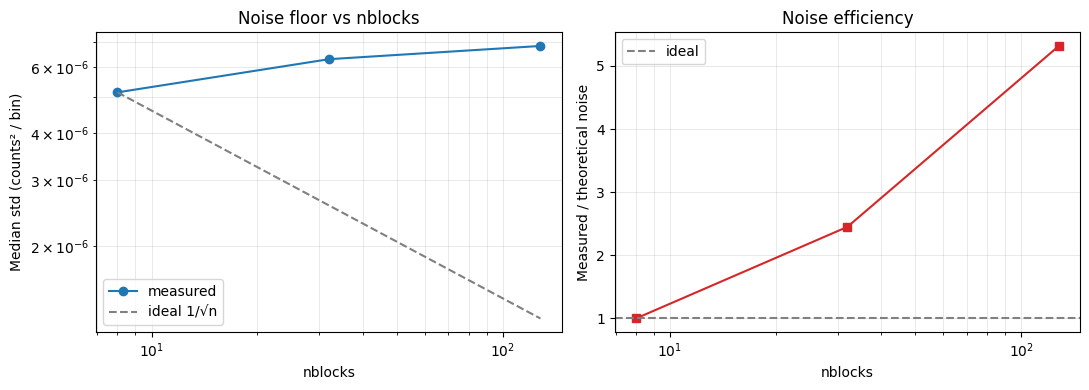

  nblocks=    8  noise=0.00001  efficiency=1.000
  nblocks=   32  noise=0.00001  efficiency=2.451
  nblocks=  128  noise=0.00001  efficiency=5.316


In [4]:
import numpy as np

ns    = np.array([n for n, _ in nblock_spectra])
noise = np.array([np.median(spec.std) for _, spec in nblock_spectra])

# Metric 2: efficiency relative to ideal 1/√nblocks scaling
theoretical = noise[0] / np.sqrt(ns / ns[0])
efficiency  = noise / theoretical

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# --- Metric 1: noise floor vs nblocks ---
ax1.loglog(ns, noise,        'o-', label='measured')
ax1.loglog(ns, theoretical,  '--', color='gray', label='ideal 1/√n')
ax1.set_xlabel('nblocks')
ax1.set_ylabel('Median std (counts² / bin)')
ax1.set_title('Noise floor vs nblocks')
ax1.legend()
ax1.grid(True, which='both', lw=0.4, alpha=0.5)

# --- Metric 2: noise efficiency ---
ax2.semilogx(ns, efficiency, 's-', color='tab:red')
ax2.axhline(1.0, color='gray', linestyle='--', label='ideal')
ax2.set_xlabel('nblocks')
ax2.set_ylabel('Measured / theoretical noise')
ax2.set_title('Noise efficiency')
ax2.legend()
ax2.grid(True, which='both', lw=0.4, alpha=0.5)

fig.tight_layout()
plt.show()

for n, s, e in zip(ns, noise, efficiency):
    print(f'  nblocks={n:>5d}  noise={s:.5f}  efficiency={e:.3f}')